In [146]:
# 모듈 불러오기
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import joblib
import matplotlib.pyplot as plt
import time
import os

In [147]:
# 데이터 불러오기
column_names = ['timestamp', 'v_raw', 'c_raw', 'voltage', 'current', 'label']
# df_normal = pd.read_csv('../realtime/raw_dataset_normal_90sec.csv', names=column_names, header=None)
# df_arc = pd.read_excel('../dataset/preprocessed/50ohm_아크_train.xlsx')
# test_df = pd.read_csv('../realtime/test/test_dataset_rf_ocsvm.csv')
test_df = pd.read_csv('../realtime/test_arc/arc_10sec_RC_1.csv')


# 컬럼명 통일
# df_normal = df_normal.rename(columns={'power_voltage': 'voltage', 'power_current': 'current'})
# df_arc = df_arc.rename(columns={'arc_voltage': 'voltage', 'arc_current': 'current'})
test_df = test_df.rename(columns={'power_voltage': 'voltage', 'power_current': 'current'})

# # 라벨 추가
# df_normal['label'] = 0
# df_arc['label'] = 1

# train_df = pd.concat([df_normal, df_arc], ignore_index=True)

In [148]:
# 파생 피처 생성 함수
def add_features(voltage_seq, current_seq):
    voltage = np.mean(voltage_seq)
    current = np.mean(current_seq)
    voltage_diff = np.abs(voltage_seq[-1] - voltage_seq[-2])
    current_diff = np.abs(current_seq[-1] - current_seq[-2])
    voltage_ma = np.mean(voltage_seq[-5:])
    current_ma = np.mean(current_seq[-5:])
    power = voltage * current
    power_diff = np.abs(power - (voltage_seq[-2] * current_seq[-2]))
    return [voltage, current, voltage_diff, current_diff, voltage_ma, current_ma, power, power_diff]

In [149]:
# 슬라이딩 윈도우로 피처 생성
def generate_sequence_features(df, window_size=8):
    features = []
    labels = []

    for i in range(window_size, len(df)):
        voltage_seq = df['voltage'].iloc[i - window_size:i].values
        current_seq = df['current'].iloc[i - window_size:i].values
        feat = add_features(voltage_seq, current_seq)
        features.append(feat)
        labels.append(df['label'].iloc[i])  # 마지막 인덱스의 라벨 사용

    return np.array(features), np.array(labels)

In [150]:
# 모델 및 스케일러 불러오기
import joblib

model = joblib.load('./model/random_forest_model_R.joblib')
scaler = joblib.load('./model/scaler_rf.joblib')

# 피처 및 라벨 설정
X_test, y_test = generate_sequence_features(test_df)

# 정규화
X_test_scaled = scaler.transform(X_test)

# 모델 예측
y_pred = model.predict(X_test_scaled)

In [151]:
# # 피처 및 라벨 설정
# # X_train, y_train = generate_sequence_features(train_df)
# X_test, y_test = generate_sequence_features(test_df)

# # 정규화
# scaler = StandardScaler()
# # X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [152]:
# # RandomForest 모델 학습
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train_scaled, y_train)

# 모델 저장
# joblib.dump(model, './model/random_forest_model.joblib')
# joblib.dump(scaler, './model/scaler_rf.joblib')

In [153]:
# # 예측 및 평가
# y_pred = model.predict(X_test_scaled)

In [154]:
def postprocess_anomalies(y_pred_bin, min_consecutive=2):
    y_post = np.zeros_like(y_pred_bin)
    count = 0
    for i, val in enumerate(y_pred_bin):
        if val == 1:
            count += 1
        else:
            if count >= min_consecutive:
                y_post[i - count:i] = 1
            count = 0
    if count >= min_consecutive:
        y_post[len(y_pred_bin)-count:] = 1
    return y_post

y_pred_post = postprocess_anomalies(y_pred, min_consecutive=8)
y_true_post = postprocess_anomalies(y_test, min_consecutive=8)

In [155]:
print("📋 (후처리 적용) 분류 리포트:\n")
print(classification_report(y_true_post, y_pred_post, target_names=['정상', '아크']))

📋 (후처리 적용) 분류 리포트:

              precision    recall  f1-score   support

          정상       0.00      0.00      0.00       0.0
          아크       0.00      0.00      0.00     592.0

    accuracy                           0.00     592.0
   macro avg       0.00      0.00      0.00     592.0
weighted avg       0.00      0.00      0.00     592.0



/opt/homebrew/anaconda3/envs/arcenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/arcenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/arcenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

In [156]:
def calculate_detection_delay(y_pred_bin, label, sampling_interval=0.0001):
    arc_start = np.where(label == 1)[0][0] # 아크의 시작 인덱스 찾기
    detected = np.where(y_pred_bin[arc_start:] == 1)[0] # 예측 값에서 아크를 처음 발견한 인덱스 찾기
    if len(detected) == 0:
        print("⚠️ 아크를 탐지하지 못했습니다.")
        return None
    detect_index = detected[0] + arc_start
    delay = detect_index - arc_start
    time_detected = detect_index * sampling_interval
    print(f"✅ 아크 시작 인덱스: {arc_start}")
    print(f"✅ 모델 이상 감지 인덱스: {detect_index}")
    print(f"⏱️ 감지 지연 시간: {delay} 샘플")
    print(f"⏱️ 감지된 시점 (초): {time_detected:.6f} 초")
    return arc_start, detect_index, delay

# arc_start, detect_index, delay = calculate_detection_delay(y_pred_post, y_true_post)


In [157]:
import time

# 전체 예측 시간
start_total = time.perf_counter()
y_pred = model.predict(X_test_scaled)
elapsed_total = time.perf_counter() - start_total
print(f"⏱️ 전체 예측 소요 시간: {elapsed_total:.10f}초")

# 후처리 + 첫 이상 감지까지 시간
start_first = time.perf_counter()
y_pred_post = postprocess_anomalies(y_pred, min_consecutive=2)
first_index = np.where(y_pred_post == 1)[0]
elapsed_first = time.perf_counter() - start_first

if len(first_index) > 0:
    print(f"🟡 첫 번째 이상 탐지 인덱스: {first_index[0]}")
    print(f"⏱️ 첫 이상 탐지까지 걸린 시간: {elapsed_first:.10f}초")
else:
    print("⚠️ 후처리된 이상 탐지 결과가 없습니다.")


⏱️ 전체 예측 소요 시간: 0.0151945420초
🟡 첫 번째 이상 탐지 인덱스: 23
⏱️ 첫 이상 탐지까지 걸린 시간: 0.0004180000초


In [158]:
# 모듈 임포트
import psutil
import os

# 리소스 사용량 출력 함수
def print_resource_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    cpu_percent = process.cpu_percent(interval=1.0)
    print(f"🧠 메모리 사용량: {mem_info.rss / 1024 ** 2:.2f} MB")
    print(f"🧮 CPU 사용률: {cpu_percent:.2f}%")


# 전체 예측 시간 측정 + 시스템 리소스 출력
print("🔍 예측 전 시스템 상태:")
print_resource_usage()

start_total = time.perf_counter()
y_pred = model.predict(X_test_scaled)
elapsed_total = time.perf_counter() - start_total

print("🔍 예측 후 시스템 상태:")
print_resource_usage()

print(f"⏱️ 전체 예측 소요 시간: {elapsed_total:.10f}초")



🔍 예측 전 시스템 상태:
🧠 메모리 사용량: 221.16 MB
🧮 CPU 사용률: 0.30%
🔍 예측 후 시스템 상태:
🧠 메모리 사용량: 221.22 MB
🧮 CPU 사용률: 0.10%
⏱️ 전체 예측 소요 시간: 0.0127462500초


---
# 시각화 자료

In [159]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (예: 맑은 고딕)
# plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 사용자
plt.rcParams['font.family'] = 'AppleGothic'   # macOS 사용자
# plt.rcParams['font.family'] = 'NanumGothic'   # Linux 사용자 (Nanum 폰트 설치 필요)

# 마이너스 부호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

In [160]:
def plot_predictions(y_pred_bin, arc_start=None, detect_index=None):
    plt.figure(figsize=(15, 4))
    plt.plot(y_pred_bin, label='예측 이상 (1=이상)', color='red', linewidth=1)

    if arc_start is not None:
        plt.axvline(x=arc_start, color='blue', linestyle='--', label='실제 아크 시작')
    if detect_index is not None:
        plt.axvline(x=detect_index, color='green', linestyle='--', label='감지된 시점')

    plt.title("Random Forest 이상 탐지 결과")
    plt.xlabel("샘플 인덱스")
    plt.ylabel("예측값")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_predictions(y_pred_post, arc_start, detect_index)

NameError: name 'arc_start' is not defined

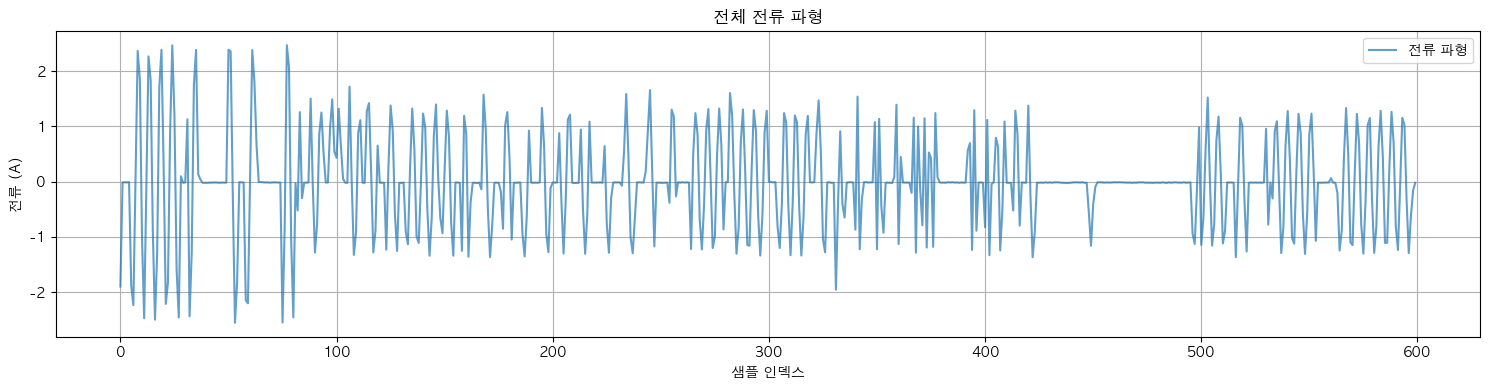

In [ ]:
def plot_current_waveform(test_df):
    plt.figure(figsize=(15, 4))
    plt.plot(test_df['current'], label='전류 파형', alpha=0.7)
    plt.title("전체 전류 파형")
    plt.xlabel("샘플 인덱스")
    plt.ylabel("전류 (A)")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

plot_current_waveform(test_df)

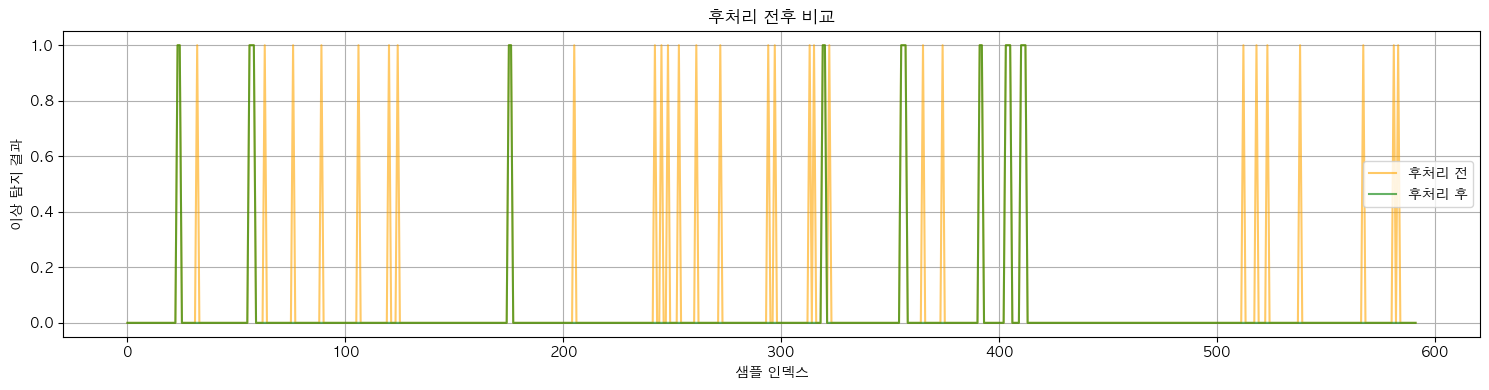

In [161]:
def compare_postprocessing(y_pred_bin, y_pred_post, title="후처리 전후 비교"):
    plt.figure(figsize=(15, 4))
    plt.plot(y_pred_bin, label='후처리 전', color='orange', alpha=0.6)
    plt.plot(y_pred_post, label='후처리 후', color='green', alpha=0.6)
    plt.title(title)
    plt.xlabel("샘플 인덱스")
    plt.ylabel("이상 탐지 결과")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

compare_postprocessing(y_pred, y_pred_post)




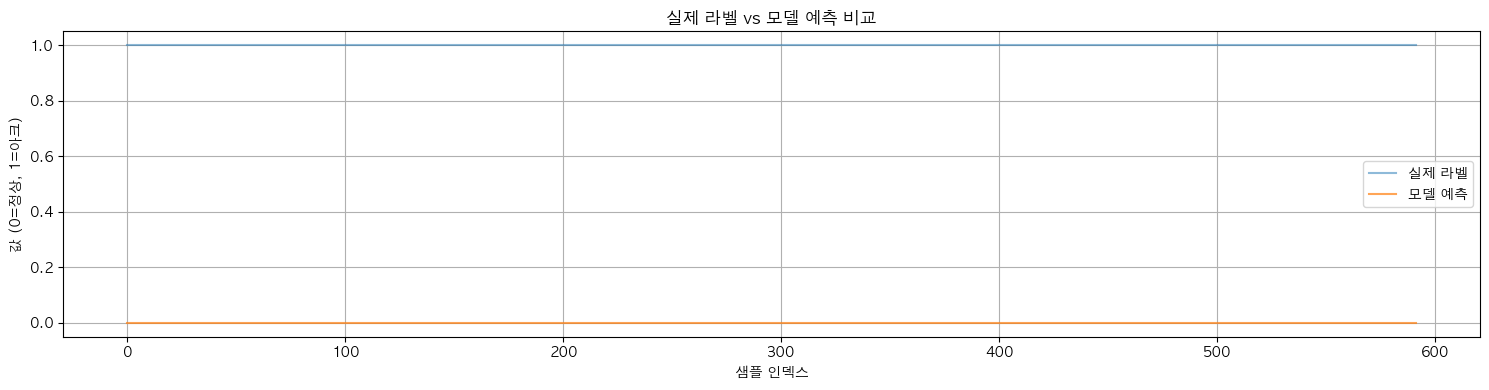

In [ ]:
def compare_prediction_vs_label(y_true, y_pred_post):
    plt.figure(figsize=(15, 4))
    plt.plot(y_true, label='실제 라벨', alpha=0.5)
    plt.plot(y_pred_post, label='모델 예측', alpha=0.7)
    plt.title("실제 라벨 vs 모델 예측 비교")
    plt.xlabel("샘플 인덱스")
    plt.ylabel("값 (0=정상, 1=아크)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

compare_prediction_vs_label(y_true_post, y_pred_post)

# # 차이점 위치 찾기
# mismatch_indices = np.where(y_true_post != y_pred_post)[0]
# print("불일치 인덱스:", mismatch_indices)
# print("불일치 개수:", len(mismatch_indices))